# Insight Data Science Fellow Background Investigation

As an intelligent data analyst/scientist creating the **`intuitive data visualzation`**, a good habit is to start with the settings of plotting toolboxes, `matplotlib` and `seaborn`


In [695]:
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144


Another good habit is to list the used Python library at the top.


In [189]:
import re
import requests
import pandas as pd
from bs4 import BeautifulSoup
import folium
from folium.plugins import MarkerCluster


There are *4 consequent sections* in this notebook presenting the end-to-end flow. On each section, including the method, the code could be investigated and further re-factored. I present and go through the code matching my best understanding so far.
1. `Web Scraping for data collection`
2. `Data Wrangle and Retrieve the Geo-Location of fellows`
3. `API and Mapping (Using Free API)`
4. `Background Investigation`


## Web Scraping for Data Collection

I navigate the website of Insight, https://www.insightdatascience.com/fellows to retrieve the background information of Insight's Fellow. Insight's website is created on a structured way which leads to the convinient way to scrap the structured data, 

The basic workflow in this section is like the following:
1. Request the html data page by page => Utilize [Requests](http://docs.python-requests.org/en/master/)
2. Scrap the html data from pages in a structued way => Recommend [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) for html data
3. Manipulate String with [Regular Expression](https://docs.python.org/3/library/re.html)
4. Store the scrapped data into Dataframe format for the further wranggling => Use [Pandas](https://pandas.pydata.org/)


In [703]:
url = 'https://www.insightdatascience.com/fellows'

In [80]:
def get_page_items(i):
    return {'url': url, 
            'params': {'61ea5d1b_page': i}
           }

In [183]:
def get_background(response):
    #html_parse
    #response = requests.get(url, params={"search_api_views_fulltext": ""})
    db = dict()
    soup = BeautifulSoup(response.text)
    parent_page = soup.find('div', attrs={'class': 'w-clearfix w-dyn-items w-row'})
    background_header = parent_page.find_all('div', attrs={'class': 'tooltip_header'})
    background = parent_page.find_all('div', attrs={'class': 'tooltip_content'})
    
    #pattern
    pat_name = re.compile(r'<div class="tooltip_name">([\S\s]+?)</div>')
    pat_title = re.compile(r'<div class="toottip_title">([\S\s]+?)</div>')
    pat_comp = re.compile(r'<div class="tooltip_company">([\S\s]+?)</div>')
    pat_back = re.compile(r'<div class="tooltip_background">([\S\s]+?)</div>')
    pat_project = re.compile(r'<div class="tooltip_project">([\S\s]+?)</div>')
    
    parse_name = list()
    parse_title = list()
    parse_comp = list()
    parse_pro = list()
    parse_study = list()
    parse_school = list()
    
    for i in background_header:
        try:
            parse_name.append(pat_name.search(str(i))[1])
        except TypeError:
            parse_name.append('')
        try:
            parse_title.append(pat_title.search(str(i))[1])
        except TypeError:
            parse_title.append('')
        try:
            parse_comp.append(pat_comp.search(str(i))[1])
        except TypeError:
            parse_comp.append('')
    
    for i in background:
        parse_pro.append(pat_project.search(str(i))[1])
        parse_back = pat_back.search(str(i))[1].split(',')
        if len(parse_back) == 3:
            parse_study.append(parse_back[0].strip())
            parse_school.append(parse_back[1].strip())
        elif len(parse_back) == 4:
            parse_study.append(parse_back[0].strip())
            parse_school.append(parse_back[1].strip() + '-' + parse_back[2].strip())
        elif len(parse_back) == 2:
            parse_study.append(parse_back[0].strip())
            parse_school.append('')
        elif len(parse_back) == 1:
            parse_study.append(parse_back[0].strip())
            parse_school.append('')
        else:
            parse_study.append('')
            parse_school.append('')
        #print(parse_back)
        
    db['name'] = parse_name
    db['title'] = parse_title
    db['company'] = parse_comp
    db['project'] = parse_pro
    db['major'] = parse_study
    db['university'] = parse_school
    
    #print(len(parse_name))
    #print(len(parse_title))
    #print(len(parse_comp))
    #print(len(parse_pro))
    #print(len(parse_study))
    #print(len(parse_school))
    
    return pd.DataFrame(data=db)

In [184]:
db = list()
for i in range(8):
    db.append(get_background(requests.get(**get_page_items(i+1))))
insight_db = pd.concat(db)

In [185]:
insight_db.head()

,name,title,company,project,major,university
0,JP Bida,Director of Risk,Capital One,Measuring the Impact of Open Source Coders on ...,Bio-X Games,Stanford
1,Douglas Mason,Data Scientist,Twitter,Email Searcher: Search &amp; Visualize Your Ma...,Physics,Harvard University
2,Virot Ta Chiraphadhanakul,Data Scientist,Facebook,Tweet Timeline: Visualizing the Impact of Soci...,Operations Research,MIT
3,Julia Viladomat,Data Scientist,Adobe,Sentiment Analysis Based on Social Media,Statistics,Stanford
4,David Freeman,Head of Anti-Abuse Engineering,LinkedIn,Flight Delay Predictor,Mathematics,Stanford



With the above-mentioned code, we retrieve `six` types of information of data science fellows:
1. **Name**
2. **Current Title**
3. **Current Company**
4. **Insight Project**
5. **Major**
6. **University**

`Reset the index` of the dataframe for the further data-wranggling


In [195]:
insight_db.reset_index(inplace=True)

insight_db.head()

,index,name,title,company,project,major,university
0,0,JP Bida,Director of Risk,Capital One,Measuring the Impact of Open Source Coders on ...,Bio-X Games,Stanford
1,1,Douglas Mason,Data Scientist,Twitter,Email Searcher: Search &amp; Visualize Your Ma...,Physics,Harvard University
2,2,Virot Ta Chiraphadhanakul,Data Scientist,Facebook,Tweet Timeline: Visualizing the Impact of Soci...,Operations Research,MIT
3,3,Julia Viladomat,Data Scientist,Adobe,Sentiment Analysis Based on Social Media,Statistics,Stanford
4,4,David Freeman,Head of Anti-Abuse Engineering,LinkedIn,Flight Delay Predictor,Mathematics,Stanford


In [192]:
len(insight_db)

794

## Data Wrangle and Retrieve the Geo-Location of fellows (Free API)

Even with the web data successfully loaded into Pandas Dataframe, the scrapped data are sometimes very row. The row data in this web-scrapping action comes from two actions:
1. Missing Data or Null Data or Non-PhD Background
2. Miss Placement in the html

The row data will further requires cleanning and can be `reasonable` manipulated sometimes.
The basic cleanning workflow is like the following:

1. Identify the null data in the dataframe
2. To see if the mis-placed data could be fixed or manipulated
3. Save the data into new csv 

The workflow can be implemented with `Pandas` 

In [196]:
insight_db[insight_db['university'] == '']

,index,name,title,company,project,major,university
40,40,Krystal St. Julien,Operations Analyst,Facebook,GeoJobr: Finding a job in today's economy,,
42,42,Matthew Folz,Data Scientist,Facebook,GameChooser: Intelligent viewing recommendatio...,Probability Theory and Stochastic Processes,
55,55,Jenelle Bray,"Manager, Security Data Science",LinkedIn,PlacePickr: Helping couples decide where to li...,Computational Structural Biology &lt;br&gt; St...,
201,1,Matt Langner,Data Scientist,Facebook,the Blogtimize/r/: Find your audience and test...,Physics,
223,23,Anne Bauer,Senior Data Scientist,The New York Times,H-1B Ready: Anticipating work visa demand,,
266,66,Immanuel Buder,Data Scientist,Wallet.AI,Reputon: Rating predictions for Airbnb,Harvard-Smithsonian Center for Astrophysics,
346,46,Evgeny Shapiro,Research Scientist,GNS Healthcare,Textbooks Unchained: Find free textbooks with ...,Evident Point Software,
363,63,Philip Nutzman,Data Scientist,Gartner,cityspinneret: Matching neighborhoods across c...,Observational Astronomy,
419,19,Yusuke Sakamoto,Data Scientist,HPE,DogMeetup: Find the best dog meetup location/time,,
506,6,Erik SjÃ¶land,Data Scientist,Janssen Pharmaceutical,commentizr: Optimize borrower comments to make...,Trexquant Investment,


In [203]:
insight_db.loc[55, 'university'] = 'Stanford'
insight_db.loc[266, 'university'] = 'Harvard'
insight_db.loc[525, 'university'] = 'University of Minnesota'
insight_db.loc[662, 'university'] = 'UC Berkeley'
insight_db.loc[690, 'university'] = 'Columbia University'
insight_db.loc[699, 'university'] = 'Cornell University'

In [205]:
insight_db = insight_db[-(insight_db['university'] == '')]
len(insight_db)

774

In [209]:
df_insight = insight_db
df_insight.drop(['index'], axis=1, inplace=True)
df_insight.head()

,name,title,company,project,major,university
0,JP Bida,Director of Risk,Capital One,Measuring the Impact of Open Source Coders on ...,Bio-X Games,Stanford
1,Douglas Mason,Data Scientist,Twitter,Email Searcher: Search &amp; Visualize Your Ma...,Physics,Harvard University
2,Virot Ta Chiraphadhanakul,Data Scientist,Facebook,Tweet Timeline: Visualizing the Impact of Soci...,Operations Research,MIT
3,Julia Viladomat,Data Scientist,Adobe,Sentiment Analysis Based on Social Media,Statistics,Stanford
4,David Freeman,Head of Anti-Abuse Engineering,LinkedIn,Flight Delay Predictor,Mathematics,Stanford


In [210]:
df_insight.to_csv('./insight_fellow.csv')


After the 1st step data clean, we would like to retrieve the geocodes of fellows by the University. There are several `API` which can catch the geocode by inputing the interests. [OpenStreet Map](http://nominatim.openstreetmap.org/) is the free API we could use to query the geocode of university. The university should be furthered cleanned and `reasonably` manipulated since [OpenStreet Map](http://nominatim.openstreetmap.org/) has the limitation to identify some wordings of the inseted University.

The basic workflow is the following:
1. Data Clean on the University Column
2. Use `API` to query the geocode from JSON and save into dataframe => Utilize [Requests](http://docs.python-requests.org/en/master/)


In [211]:
fellow_university = df_insight['university'].unique()

1. Identify non-meaning `ASCII` characters and ignore  
2. Identify `&amp` and substitute with `and` word 
3. Identify `one word` and add an `University` after

In [454]:
db = dict()
fellow_university_rename = list()
for i in fellow_university:
    try:
        match = re.search(pattern='(\w*)[âÂ]\W+([\s\wfÃ©dÃ]+)', string=i)
        fellow_university_rename.append(match[1]+match[2])
    
    except TypeError:
        sub = re.sub(pattern='&amp;', repl='and', string=i)
        fellow_university_rename.append(sub)

db['university'] = fellow_university
db['university_rename'] = fellow_university_rename
df_university = pd.DataFrame(data=db)

for i in range(len(df_university)):
    if len(df_university.iloc[i, 1].split()) == 1:
        df_university.iloc[i, 1] = df_university.iloc[i, 1] + ' University USA'

In [455]:
df_university

,university,university_rename
0,Stanford,Stanford University USA
1,Harvard University,Harvard University
2,MIT,MIT University USA
3,Duke,Duke University USA
4,UC Riverside,UC Riverside
5,Virgina Tech,Virgina Tech
6,UC Berkeley,UC Berkeley
7,Johns Hopkins University,Johns Hopkins University
8,Harvard,Harvard University USA
9,Â Lawrence Berkeley National Laboratory,Lawrence Berkeley National Laboratory



Use `FreeAPI` with Requests to catch geocodes, latitude and longitude


In [436]:
def geocode(address):
    params = { 'format'        :'json', 
               'polygon_geojson': 1, 
               'q'             : address}
    return requests.get('http://nominatim.openstreetmap.org/search', params=params)

In [462]:
lat = list()
lon = list()
#geojson = list()
nolist = list()
for i in df_university['university_rename']:
    response = geocode(i)
    try:
        lat.append(response.json()[0]['lat'])
        lon.append(response.json()[0]['lon'])
        #geojson.append(response.json()[0]['geojson'])
    except IndexError:
        lat.append('')
        lon.append('')
        #geojson.append('')
        nolist.append(i)  

In [468]:
nolist_num = [n for n, i in enumerate(lat) if i == '']

In [704]:
len(nolist_num)

58

There are 58 wordings of university that could not be serached inside [OpenStreet Map](http://nominatim.openstreetmap.org/), and these required further re-wordings

In [464]:
nolist

['Virgina Tech',
 'University Carlos III of Madrid',
 'Computation and Neural Systems-MIT',
 'Kavli Institute for Theoretical Physics-UC Santa Barbara',
 'Stanford/University of Michigan',
 'Georgia Institute of Technology/Emory University',
 'Wisconsin IceCube Particle Astrophysics Center',
 'Pardee RAND Graduate School',
 'University of Colorado Boulde',
 'University of Waterloo and Perimeter Institute for Theoretical Physics',
 'ECARES-ULB University USA',
 'Oracle University USA',
 'UCSF/UC Berkeley',
 'Senseable City Lab / Singapore - MIT Alliance for Research and Technology',
 'DNVGL University USA',
 'Mount Sinai School of Medicine',
 'NYC School of Medicine',
 'Boston University and Broad Institute',
 'Harvard-Smithsonian Center for Astrophysics',
 'WiTricity Corporation',
 'Agricultural Microfinance-One Acre Fund',
 'Icahn School of Medicine at Mount Sinai',
 'UCSF-Assistant Professor',
 'Duimstra Consulting',
 'Graphene Frontiers',
 'Istituto Nazionale di Fisica Nucleare-Sezi

In [469]:
nolist_change = ['Virginia Polytechnic Institute',
                 'Universidad Carlos III de Madrid',
                 'MIT University',
                 'UCSB University USA',
                 'Stanford University',
                 'Georgia Institute of Technology',
                 'University of Wisconsin',
                 'Pardee RAND',
                 'University of Colorado Boulder',
                 'University of Waterloo',
                 'Université Libre de Bruxelles',
                 'Oracle University',
                 'UCSF University USA',
                 'MIT University',
                 'DNVGL University',
                 'Mount Sinai School USA',
                 'NYU School of Medicine',
                 'Boston University',
                 'Harvard University',
                 '57 Water St, Watertown, MA 02472',
                 '888 16th St NW Washington, DC 20006',
                 'Mount Sinai School USA',
                 'UCSF University USA',
                 'Duimstra Consulting',
                 '3624 Market St, Philadelphia, PA 19104',
                 'Istituto Nazionale di Fisica Nucleare',
                 "Institut d'Astrophysique de Paris",
                 'Georgia Institute of Technology',
                 'Nathan Kline Institute',
                 'United States Military Academy',
                 'Potsdam Institute',
                 'NYU',
                 'University of Maryland College Park',
                 'Universidad Complutense de Madrid',
                 'Integrated Brain Imaging Center',
                 'University of Massachusetts Amherst',
                 'Texas A and M University',
                 'Institute for High Energy Physics',
                 'École Polytechnique Fédérale de Lausanne',
                 'French Space Agency',
                 'Northwestern University',
                 'University of Texas at Austin',
                 'SUNY College USA',
                 'Max-Planck Institute',
                 'Weill Cornell',
                 'Max-Planck Institute',
                 '8045 Lamon Ave, Skokie, IL 60077',
                 'University of Massachusetts Amherst',
                 'University of Missouri',
                 'University of Trento Italy',
                 '902 Battelle Blvd, Richland, WA 99354',
                 'Salk Institute',
                 'Sapling Learning',
                 'Intel Oregon',
                 'University of Washington',
                 'Ames Laboratory',
                 'NASA',
                 'CERN'
                ]

In [477]:
for n, i in enumerate(nolist_num):
    df_university.iloc[i, 1] = nolist_change[n]

In [478]:
df_university

,university,university_rename
0,Stanford,Stanford University USA
1,Harvard University,Harvard University
2,MIT,MIT University USA
3,Duke,Duke University USA
4,UC Riverside,UC Riverside
5,Virgina Tech,Virginia Polytechnic Institute
6,UC Berkeley,UC Berkeley
7,Johns Hopkins University,Johns Hopkins University
8,Harvard,Harvard University USA
9,Â Lawrence Berkeley National Laboratory,Lawrence Berkeley National Laboratory


In [481]:
lat = list()
lon = list()
#geojson = list()
nolist = list()
for i in df_university['university_rename']:
    response = geocode(i)
    try:
        lat.append(response.json()[0]['lat'])
        lon.append(response.json()[0]['lon'])
        #geojson.append(response.json()[0]['geojson'])
    except IndexError:
        lat.append('')
        lon.append('')
        #geojson.append('')
        nolist.append(i)  

In [484]:
df_university['lat'] = lat
df_university['lon'] = lon
df_university.head()

,university,university_rename,lat,lon
0,Stanford,Stanford University USA,37.43131385,-122.169365354983
1,Harvard University,Harvard University,42.36782045,-71.1266665287448
2,MIT,MIT University USA,42.3583961,-71.0956778766393
3,Duke,Duke University USA,36.0001557,-78.9442297219588
4,UC Riverside,UC Riverside,-41.4153427,147.1028942


`Merge` Two Dataframes as One

In [487]:
df_insight_fellow = pd.merge(df_insight, df_university, how='left', on=['university'])
print(len(df_insight_fellow))
df_insight_fellow.head()

774


,name,title,company,project,major,university,university_rename,lat,lon
0,JP Bida,Director of Risk,Capital One,Measuring the Impact of Open Source Coders on ...,Bio-X Games,Stanford,Stanford University USA,37.43131385,-122.169365354983
1,Douglas Mason,Data Scientist,Twitter,Email Searcher: Search &amp; Visualize Your Ma...,Physics,Harvard University,Harvard University,42.36782045,-71.1266665287448
2,Virot Ta Chiraphadhanakul,Data Scientist,Facebook,Tweet Timeline: Visualizing the Impact of Soci...,Operations Research,MIT,MIT University USA,42.3583961,-71.0956778766393
3,Julia Viladomat,Data Scientist,Adobe,Sentiment Analysis Based on Social Media,Statistics,Stanford,Stanford University USA,37.43131385,-122.169365354983
4,David Freeman,Head of Anti-Abuse Engineering,LinkedIn,Flight Delay Predictor,Mathematics,Stanford,Stanford University USA,37.43131385,-122.169365354983


Final DataFrame with the filtering of non geocode data; the original total # of fellow is 794, `768` right now

In [493]:
df_insight_fellow = df_insight_fellow[-(df_insight_fellow['lat'] == '')]
len(df_insight_fellow)

768

## API and Mapping


In this section, we utilize [Folium Map](https://python-visualization.github.io/folium/docs-v0.6.0/) to have the interactive marker. In addition, we can also have the plugin function of `MarkerCluster` to have the interactive aggregated number of regional cluster shown in Map


In [613]:
us_map = folium.Map(location=[37.09024, -95.712891], zoom_start=4.25)

In [618]:
marker_cluster = MarkerCluster().add_to(us_map)

In [619]:
for i in df_insight_fellow.index:
    popup = df_insight_fellow.loc[i, 'name']
    lat = float(df_insight_fellow.loc[i, 'lat'])
    lon = float(df_insight_fellow.loc[i, 'lon'])
    folium.Marker(
        location=[lat, lon],
        #popup=popup,
        icon=folium.Icon(color='green', icon='cloud')
    ).add_to(marker_cluster)

In [620]:
us_map


With the map and marker, we can easily see Fellows are clustered into the certain regions, including `California, Washignton, Arizona, Texas, Mid-West, New York and New England` (Of course, there are fellows from Europe, Canada, and Asia)


In [621]:
us_map.save(outfile='mapping_results.html')

## Background Investigation

In this section, we would use the following functions to have the background check of fellows:
1. `Pandas Apply` => This is similar as `SQL` `casewhen` to have the catogorized data
2. Visualize the distribution of the major => Use [Seaborn](https://seaborn.pydata.org/index.html)


In [628]:
df_insight_fellow['major'] = df_insight_fellow['major'].str.lower()

def casewhen(row):
    major_list = ['physics', 'science', 'bio', 'engineer', 'stat', 'math', 
                  'chemi', 'gen', 'math', 'econ', 'astronomy', 'med', 
                  'psychology', 'research', 'analy']
    major_cat = 'others'
    for i in major_list:
        if i in row:
            major_cat = i
            break
    return major_cat

In [689]:
df_insight_fellow['major_cat'] = df_insight_fellow['major'].apply(func=casewhen)

In [690]:
df_insight_fellow.head()

,name,title,company,project,major,university,university_rename,lat,lon,major_cat
0,JP Bida,Director of Risk,Capital One,Measuring the Impact of Open Source Coders on ...,bio-x games,Stanford,Stanford University USA,37.43131385,-122.169365354983,bio
1,Douglas Mason,Data Scientist,Twitter,Email Searcher: Search &amp; Visualize Your Ma...,physics,Harvard University,Harvard University,42.36782045,-71.1266665287448,physics
2,Virot Ta Chiraphadhanakul,Data Scientist,Facebook,Tweet Timeline: Visualizing the Impact of Soci...,operations research,MIT,MIT University USA,42.3583961,-71.0956778766393,research
3,Julia Viladomat,Data Scientist,Adobe,Sentiment Analysis Based on Social Media,statistics,Stanford,Stanford University USA,37.43131385,-122.169365354983,stat
4,David Freeman,Head of Anti-Abuse Engineering,LinkedIn,Flight Delay Predictor,mathematics,Stanford,Stanford University USA,37.43131385,-122.169365354983,math


In [692]:
df_insight_fellow['major_cat'].value_counts()

physics       274
science       146
bio            90
engineer       70
others         61
math           39
stat           14
psychology     14
chemi          13
astronomy      13
gen            10
analy           9
econ            8
research        4
med             3
Name: major_cat, dtype: int64

Text(0, 0.5, 'background')

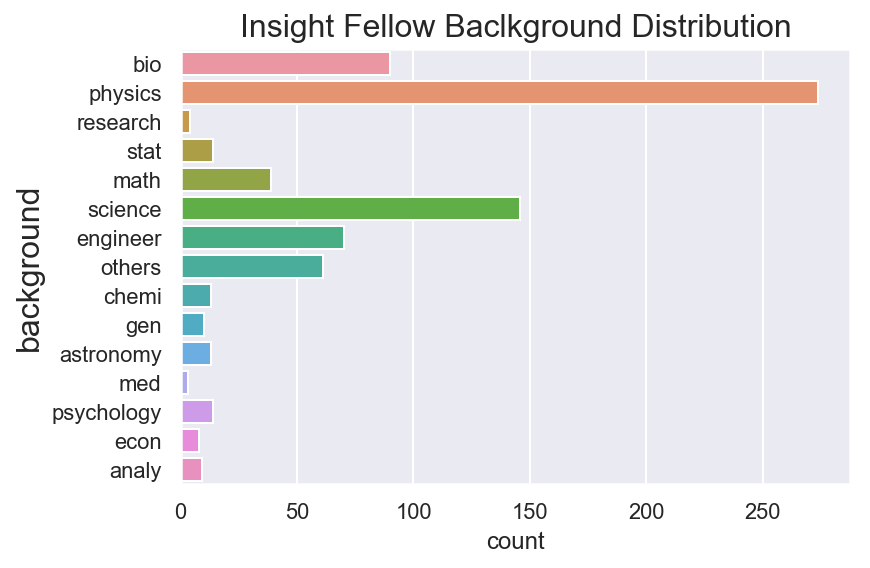

In [699]:
sns.set(style='darkgrid')
ax = sns.countplot(y='major_cat', data=df_insight_fellow)
ax.set_title('Insight Fellow Baclkground Distribution', fontsize=16)
ax.set_ylabel('background', fontsize=16)

It can be easily observed that top-4 majors of fellows are:
1. Physics
2. Science
3. Bio-Related
4. Engineering

`Quant` and `Analytic` skills are highly emphasized in Insight DataScience Program


**Bonus:** Try to see how many fellows come from my school, [University of Arizona](https://www.arizona.edu)

In [701]:
df_insight_fellow[df_insight_fellow['university'] == 'University of Arizona']

,name,title,company,project,major,university,university_rename,lat,lon,major_cat
236,Jonathan Eckel,Senior Data Scientist,Splash,"beersomme: Find a bar, drink awesome beer!",physics,University of Arizona,University of Arizona,33.45205165,-112.063678942176,physics
364,Nikita Kirnosov,Data Scientist,Google,Illseeitall: Optimize your schedule to see the...,chemical physics,University of Arizona,University of Arizona,33.45205165,-112.063678942176,physics
532,Alex Abate,Data Scientist,Dia&amp;Co,Market Insight: Visualise the potential of NYC...,astrophysics,University of Arizona,University of Arizona,33.45205165,-112.063678942176,physics
